# 【Azure AIとIntel AIコラボ企画】
# Azure Custom Visionでモデルを作って、OpenVINOで高速推論するサンプル
Azureの便利なAIサービスとIntelのAIツール使ったコラボレーションサンプルです。
このサンプルでは、Azure Cognitive Servicesの一つであるCustom Visionにて画像分類モデルを構築し、当該モデルをIntel OpenVINO ToolkitでIA上で高速推論してみます。

なお、このサンプルでは犬と猫の画像を計37種類のいずれに分類するモデルを作成します。
<table border="0">
<tr>
<td><center>Abyssinian</center></td>
<td><center>American pit bull</center></td>
<td><center>Beagle</center></td>
<td><center>Bengal</center></td>
<td><center>Birman</center></td>
<td><center>Boxer</center></td>
<td><center>・・・</center></td>
</tr>
<tr>
<td><img src="./images/Abyssinian_9.jpg" width="112"></td>
<td><img src="./images/american_pit_bull_terrier_98.jpg" width="112"></td>
<td><img src="./images/beagle_82.jpg" width="112"></td>
<td><img src="./images/Bengal_121.jpg" width="112"></td>
<td><img src="./images/Birman_17.jpg" width="112"></td>
<td><img src="./images/boxer_54.jpg" width="112"></td>
<td><center>・・・</center><br/>(こういう感じで計37種類あります)</td>
</tr>
</table>

モデル作成後、まずはProtobuf形式のモデルをTensorflowを用いて推論してみます。
続いて、同モデルをOpenVINOのIR形式に変換し、同様の画像を対象に推論してみます。
推論性能がどの程度変化するかご体験ください。

## 前提条件：
- Azureのアカウントを持っており、Azure Portalへのログインができること
- Azure VM「Intel Optimized Data Science VM」を作成していること
    - 作成手順は[こちら](https://www.intel.ai/intel-optimized-data-science-virtual-machine-azure/)を参照
- 上記VMにIntel OpenVINO™ Toolkitの最新版をインストールしていること
    - インストール手順は[こちら](https://docs.openvinotoolkit.org/latest/_docs_install_guides_installing_openvino_linux.html)を参照

## 学習：Azure Custom Vision でのモデルを作成する
https://docs.microsoft.com/ja-jp/azure/cognitive-services/custom-vision-service/getting-started-build-a-classifier

1. [Azure Portal](https://portal.azure.com/)へログインする
1. ホーム画面の「リソースの作成」をクリック
1. 検索フォームに「Custom Vision」と入力してEnter
1. Custom Visionの作成画面が表示されるので「作成」ボタンを押下
1. 以下のように入力
    1. 名前：適当な名前を入力
    1. サブスクリプション：Azure for Studentsを選択
    1. リソースグループ：新規作成を押下して、適当な名前を入力
    1. トレーニングの場所：（アジア太平洋）東日本　を選択
    1. トレーニングの価格レベル： S0　を選択
    1. 予測の場所：（アジア太平洋）東日本　を選択
    1. 予測の価格レベル：S0　を選択
1. 作成ボタンを押下。（少し待ちます）
1. 作成が完了したことを確認したら、[Custom Visionのポータル](https://www.customvision.ai/)に移動
1. 「SIGN IN」をクリックして、ログイン
1. 「New Project」をクリック
1. 以下のように入力
    1. Name：適当に入力
    1. Description：空白でOK
    1. Resource：先ほど作成した「○○customvision」を選択
    1. Project Types：Classification　を選択学習
    1. Classification Types：Multiclass (Single tag per image)　を選択
    1. Domains：General(Compact)　を選択
    1. Export Capabilities：Basic Platform　を選択
1. Createボタンを押下
1. Project画面にて、「Add Images」ボタンを押下
1. ローカルPCのディレクトリから学習用画像が入っている「Train」フォルダへ移動し、適当なカテゴリフォルダを開く
1. カテゴリフォルダ配下の画像を全選択し、「Open」を押下
1. Image Uploadというダイアログが開くので、「My Tags」にカテゴリ名を入力し、Upload ○○ files ボタンを押下
1. 上記をカテゴリ数（37個）分繰り返す。または、下記スクリプトを実行して、全画像をバッチでアップロードする。
1. 画像アップロード、および、タグ付けが完了したら画面右上のTrainボタンを押下し、Quick Trainingを選択してTrainボタンを押下
1. しばらくしてトレーニングが完了するので、結果を確認
1. 画面真ん中上部のExportを押下し、Tensorflowをクリック、Choose a versionでTensorflowを選択し、Exportボタンを押下、するとボタンがDownloadボタンに変わるので、それを押下すると、モデルがZIP形式でローカルPCにダウンロードされる。   


### （Option）画像をバッチでアップロードするためのスクリプト
上記手順の15～16の作業を自動化するスクリプトです。必要に応じてお使いください。

In [ ]:
# まずはCustom VisionのSDKをインストールする必要があります
!pip install azure-cognitiveservices-vision-customvision

In [ ]:
# 学習用の画像をバッチでCustom Visionへアップロードし、同時にタグ付け（正解ラベル付与）も行うスクリプトです

from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateEntry
import glob
import os

def upload_images(batch_size=64):
    if batch_size <= 0 or batch_size > 64:
        batch_size = 64
        
    # training_keyはAzure PortalのCustom Visionの画面にて、Endpointにて確認できます。皆さんの独自のエンドポイントに置き換えてください。
    ENDPOINT = "https://hiouchiycustomvision.cognitiveservices.azure.com/"

    # training_keyはAzure PortalのCustom Visionの画面にて、Keyにて確認できます。皆さんの独自のキーに置き換えてください。
    training_key = "1868b0e3ee1f414ab00a2f52b47ce6be"
    trainer = CustomVisionTrainingClient(training_key, endpoint=ENDPOINT)

    print ("Refering project...")

    # この文字列はCustom VisionのProject IDです。Custom Visionのポータル画面の右上の歯車マークを押して、
    # Project Settings画面のProject IDをコピーしてください
    project = trainer.get_project("9aa986ee-fda7-4bfd-a783-65c39328930c")

    print("Adding images...")
    image_list = []
    tags_dic = {}
    tag_list = trainer.get_tags(project.id)
    for tag in tag_list:
        tags_dic[tag.name] = tag.id
    file_list = glob.glob("train/*/*")
    count = 0
    image_count = 0
    uploaded_images = 0
    for file in file_list:
        image_count = image_count + 1
        if count < batch_size :
            img_cat = os.path.split(os.path.dirname(file))[1]
            if img_cat in tags_dic.keys(): 
                tag_id = tags_dic[img_cat]
            else:
                tag = trainer.create_tag(project.id, img_cat)
                tag_id = tag.id
                tags_dic[img_cat] = tag_id

            with open(file, "rb") as image_contents:
                image_list.append(ImageFileCreateEntry(name=file, contents=image_contents.read(), tag_ids=[tag_id]))
            count = count + 1
            
            if count == batch_size or image_count == len(file_list):
                count = 0
                upload_result = trainer.create_images_from_files(project.id, images=image_list)
                if not upload_result.is_batch_successful:
                    print("Image batch upload failed.")
                    for image in upload_result.images:
                        print("Image status: ", image.status)
                    exit(-1)
                else:
                    uploaded_images = uploaded_images + len(image_list)
                    print("Uploaded " + str(int((uploaded_images / len(file_list))*100.0)) + "% of total images.")
                image_list.clear()
        
    print("Uploaded " + str(len(file_list)) + " images.")

In [ ]:
upload_images(batch_size=64)

## 推論①：Azureのドキュメント通りに推論スクリプトを実装して実行してみる
https://docs.microsoft.com/ja-jp/azure/cognitive-services/custom-vision-service/export-model-python

In [1]:
import tensorflow as tf
import os
from PIL import Image
import numpy as np
import cv2
import time #ここ追加

def convert_to_opencv(image):
    # RGB -> BGR conversion is performed as well.
    image = image.convert('RGB')
    r,g,b = np.array(image).T
    opencv_image = np.array([b,g,r]).transpose()
    return opencv_image

def crop_center(img,cropx,cropy):
    h, w = img.shape[:2]
    startx = w//2-(cropx//2)
    starty = h//2-(cropy//2)
    return img[starty:starty+cropy, startx:startx+cropx]

def resize_down_to_1600_max_dim(image):
    h, w = image.shape[:2]
    if (h < 1600 and w < 1600):
        return image

    new_size = (1600 * w // h, 1600) if (h > w) else (1600, 1600 * h // w)
    return cv2.resize(image, new_size, interpolation = cv2.INTER_LINEAR)

def resize_to_256_square(image):
    h, w = image.shape[:2]
    return cv2.resize(image, (256, 256), interpolation = cv2.INTER_LINEAR)

def update_orientation(image):
    exif_orientation_tag = 0x0112
    if hasattr(image, '_getexif'):
        exif = image._getexif()
        if (exif != None and exif_orientation_tag in exif):
            orientation = exif.get(exif_orientation_tag, 1)
            # orientation is 1 based, shift to zero based and flip/transpose based on 0-based values
            orientation -= 1
            if orientation >= 4:
                image = image.transpose(Image.TRANSPOSE)
            if orientation == 2 or orientation == 3 or orientation == 6 or orientation == 7:
                image = image.transpose(Image.FLIP_TOP_BOTTOM)
            if orientation == 1 or orientation == 2 or orientation == 5 or orientation == 6:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
    return image

def run_normal(imageFile):
    start1 = time.time() #ここ追加
    
    graph_def = tf.compat.v1.GraphDef()
    labels = []

    # These are set to the default names from exported models, update as needed.
    filename = "model.pb"
    labels_filename = "labels.txt"

    # Import the TF graph
    with tf.io.gfile.GFile(filename, 'rb') as f:
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')

    # Create a list of labels.
    with open(labels_filename, 'rt') as lf:
        for l in lf:
            labels.append(l.strip())

    # Load from a file
    image = Image.open(imageFile)

    # Update orientation based on EXIF tags, if the file has orientation info.
    image = update_orientation(image)

    # Convert to OpenCV format
    image = convert_to_opencv(image)

    # If the image has either w or h greater than 1600 we resize it down respecting
    # aspect ratio such that the largest dimension is 1600
    image = resize_down_to_1600_max_dim(image)

    # We next get the largest center square
    h, w = image.shape[:2]
    min_dim = min(w,h)
    max_square_image = crop_center(image, min_dim, min_dim)

    # Resize that square down to 256x256
    augmented_image = resize_to_256_square(max_square_image)

    # Get the input size of the model
    with tf.compat.v1.Session() as sess:
        input_tensor_shape = sess.graph.get_tensor_by_name('Placeholder:0').shape.as_list()
    network_input_size = input_tensor_shape[1]

    # Crop the center for the specified network_input_Size
    augmented_image = crop_center(augmented_image, network_input_size, network_input_size)

    # These names are part of the model and cannot be changed.
    output_layer = 'loss:0'
    input_node = 'Placeholder:0'

    with tf.compat.v1.Session() as sess:
        try:
            prob_tensor = sess.graph.get_tensor_by_name(output_layer)
            start2 = time.time() #ここ追加
            predictions,  = sess.run(prob_tensor, {input_node: [augmented_image] })
            infer_time = time.time() - start2
        except KeyError:
            print ("Couldn't find classification output layer: " + output_layer + ".")
            print ("Verify this a model exported from an Object Detection project.")
            exit(-1)

        # Print the highest probability label
        highest_probability_index = np.argmax(predictions)
        total_time = time.time() - start1
        print(imageFile + ',', 'Total Time: ' + str(int(total_time*1000.0)) + 'msec,', 'Infer Time: ' + str(int(infer_time*1000.0)) + 'msec,', 'Pred Label: ' + labels[highest_probability_index]) #ここ追加

In [3]:
#テスト用の画像をランダムに選択して推論実行
import glob
import random

file_list = glob.glob("test/*/*")
img_path = random.choice(file_list)
run_normal("sample.jpg")

sample.jpg, Total Time: 409msec, Infer Time: 316msec, Pred Label: staffordshire_bull_terrier


# 推論②：上記推論スクリプトをリファクタリングして高速化
前述のスクリプトだと、かなり処理が遅かったと思われます。
ここでは、前述のスクリプトをリファクタリングすることで、高速化を図ります。（まだOpenVINOは使いません。）

### まずはスーパークラス

In [4]:
import tensorflow as tf
import os
from PIL import Image
import numpy as np
import cv2
import time #ここ追加

class Model(object):

    def __init__(self):
        self.labels = []
        labels_filename = "labels.txt"

        # Create a list of labels.
        with open(labels_filename, 'rt') as lf:
            for l in lf:
                self.labels.append(l.strip())

    def predict(self, imageFile):
        raise NotImplementedError
    
    def convert_to_opencv(image):
        # RGB -> BGR conversion is performed as well.
        image = image.convert('RGB')
        r,g,b = np.array(image).T
        opencv_image = np.array([b,g,r]).transpose()
        return opencv_image

    def crop_center(img,cropx,cropy):
        h, w = img.shape[:2]
        startx = w//2-(cropx//2)
        starty = h//2-(cropy//2)
        return img[starty:starty+cropy, startx:startx+cropx]

    def resize_down_to_1600_max_dim(image):
        h, w = image.shape[:2]
        if (h < 1600 and w < 1600):
            return image

        new_size = (1600 * w // h, 1600) if (h > w) else (1600, 1600 * h // w)
        return cv2.resize(image, new_size, interpolation = cv2.INTER_LINEAR)

    def resize_to_256_square(image):
        h, w = image.shape[:2]
        return cv2.resize(image, (256, 256), interpolation = cv2.INTER_LINEAR)

    def update_orientation(image):
        exif_orientation_tag = 0x0112
        if hasattr(image, '_getexif'):
            exif = image._getexif()
            if (exif != None and exif_orientation_tag in exif):
                orientation = exif.get(exif_orientation_tag, 1)
                # orientation is 1 based, shift to zero based and flip/transpose based on 0-based values
                orientation -= 1
                if orientation >= 4:
                    image = image.transpose(Image.TRANSPOSE)
                if orientation == 2 or orientation == 3 or orientation == 6 or orientation == 7:
                    image = image.transpose(Image.FLIP_TOP_BOTTOM)
                if orientation == 1 or orientation == 2 or orientation == 5 or orientation == 6:
                    image = image.transpose(Image.FLIP_LEFT_RIGHT)
        return image

### 続いて、Tensorflowモデルのサブクラス

In [5]:
import tensorflow as tf
import os
from PIL import Image
import numpy as np
import cv2
import time #ここ追加

class TFModel(Model):

    def __init__(self):
        super(TFModel, self).__init__()
        
        graph_def = tf.compat.v1.GraphDef()

        # These are set to the default names from exported models, update as needed.
        filename = "model.pb"

        # Import the TF graph
        with tf.io.gfile.GFile(filename, 'rb') as f:
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session()
                
    def predict(self, imageFile):
        start1 = time.time() #ここ追加

        # Load from a file
        image = Image.open(imageFile)

        # Update orientation based on EXIF tags, if the file has orientation info.
        image = update_orientation(image)

        # Convert to OpenCV format
        image = convert_to_opencv(image)

        # If the image has either w or h greater than 1600 we resize it down respecting
        # aspect ratio such that the largest dimension is 1600
        image = resize_down_to_1600_max_dim(image)

        # We next get the largest center square
        h, w = image.shape[:2]
        min_dim = min(w,h)
        max_square_image = crop_center(image, min_dim, min_dim)

        # Resize that square down to 256x256
        augmented_image = resize_to_256_square(max_square_image)

        # Get the input size of the model
        input_tensor_shape = self.sess.graph.get_tensor_by_name('Placeholder:0').shape.as_list()
        network_input_size = input_tensor_shape[1]

        # Crop the center for the specified network_input_Size
        augmented_image = crop_center(augmented_image, network_input_size, network_input_size)
        frame = augmented_image

        # These names are part of the model and cannot be changed.
        output_layer = 'loss:0'
        input_node = 'Placeholder:0'

        try:
            prob_tensor = self.sess.graph.get_tensor_by_name(output_layer)
            start2 = time.time() #ここ追加
            predictions, = self.sess.run(prob_tensor, {input_node: [augmented_image] })
            infer_time = time.time() - start2
        except KeyError:
            print ("Couldn't find classification output layer: " + output_layer + ".")
            print ("Verify this a model exported from an Object Detection project.")
            exit(-1)

        # Print the highest probability label
        highest_probability_index = np.argmax(predictions)
        total_time = time.time() - start1
        
        return total_time, infer_time, self.labels[highest_probability_index], frame  #ここ追加

### 推論用関数を定義

In [6]:
import glob
import random
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras import models
import numpy as np
import glob
import random
import time
import os
import cv2
import pandas as pd
from PIL import Image
import PIL
import io
import IPython.display
from IPython.display import clear_output

def run_inference(model_type, target_device='CPU', total=50):
    if model_type == 'tf':
        model = TFModel()
    else:
        if target_device == 'GPU':
            model = OpenVINOModel('GPU')
        elif target_device == 'MYRIAD':
            model = OpenVINOModel('MYRIAD')
        else:
            model = OpenVINOModel('CPU')

    total_infer_spent_time = 0
    total_spent_time = 0
    list_df = pd.DataFrame( columns=['正解ラベル','予測ラベル','全処理時間(msec)','推論時間(msec)'] )

    for i in range(total):
        file_list = glob.glob("../demo2/val/*/*")
        img_path = random.choice(file_list)
        img_cat = os.path.split(os.path.dirname(img_path))[1]
        total_time, infer_time, pred_label, frame = model.predict(img_path)

        total_infer_spent_time += infer_time
        total_spent_time += total_time

        #print(img_path, str(int(total_time*1000.0)) + 'msec', str(int(infer_time*1000.0)) + 'msec', pred_label) #ここ追加
        clear_output(wait=True)
        cv2.putText(frame, str(i) + ':', (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,2550), 4)
        cv2.putText(frame, str(i) + ':', (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
        cv2.putText(frame, str(img_cat), (10,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,2550), 4)
        cv2.putText(frame, str(img_cat), (10,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
        cv2.putText(frame, str(pred_label), (10,130), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,2550), 4)
        cv2.putText(frame, str(pred_label), (10,130), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)

        f = io.BytesIO()
        PIL.Image.fromarray(frame).save(f, 'jpeg')
        IPython.display.display(IPython.display.Image(data=f.getvalue()))

        tmp_se = pd.Series( [img_cat, pred_label, str(int(total_time * 1000)), str(int(infer_time * 1000)) ], index=list_df.columns )
        list_df = list_df.append( tmp_se, ignore_index=True ) 

    clear_output(wait=True)
    print()
    print('全' + str(total) + '枚 完了！')
    print()
    print("平均処理時間: " + str(int((total_spent_time / total)*1000.0)) + " ms/枚")
    print("平均推論時間: " + str(int((total_infer_spent_time / total)*1000.0)) + " ms/枚")
    display(list_df)

    return int((total_spent_time / total)*1000.0), int((total_infer_spent_time / total)*1000.0)

Using TensorFlow backend.


### 推論実行

In [7]:
tf_total_time, tf_infer_time = run_inference('tf', total=50)


全50枚 完了！

平均処理時間: 27 ms/枚
平均推論時間: 24 ms/枚


,正解ラベル,予測ラベル,全処理時間(msec),推論時間(msec)
0,english_cocker_spaniel,english_setter,326,323
1,keeshond,keeshond,27,19
2,sphynx,sphynx,23,20
3,siamese,siamese,22,19
4,british_shorthair,ragdoll,23,20
5,bombay,bombay,23,21
6,sphynx,sphynx,22,19
7,yorkshire_terrier,yorkshire_terrier,20,18
8,beagle,american_bulldog,19,17
9,american_pit_bull_terrier,staffordshire_bull_terrier,21,19


# 推論③：Intel OpenVINO™ Toolkitを使うことで更に高速化
ひとつ前の改変により、Tensorflow上であってもモデルの推論処理がそれなりに高速化しました。
ここでは、更なる高速化のためにIntel OpenVINO™ Toolkitを使ってみます。

## まずはProtobuf形式のモデルをOpenVINOのIR形式に変換

OpenVINOに付属しているModel Optimizerを使います。
大前提として、OSの環境変数に下記がセットされている必要があります。

PYTHONPATH=c:\Program Files (x86)\IntelSWTools\openvino\python\python3.6;c:\Program Files (x86)\IntelSWTools\openvino\python\python3;

より詳しい説明は下記URLをご覧ください。 https://docs.openvinotoolkit.org/latest/_docs_MO_DG_prepare_model_convert_model_Converting_Model.html

In [ ]:
!python "c:\Program Files (x86)\IntelSWTools\openvino\deployment_tools\model_optimizer\mo.py" --input_model=model.pb --input_shape=[1,224,224,3]

この後で同モデルをNeural Compute Stick2上で実行するため、FP16形式にも変換しておきます。（NCS2はFP16のみ対応のため）

In [ ]:
!python "c:\Program Files (x86)\IntelSWTools\openvino\deployment_tools\model_optimizer\mo.py" --input_model=model.pb --input_shape=[1,224,224,3] --data_type=FP16 --model_name=model.fp16

## 続いて、OpenVINOモデルのサブクラスを記述

In [8]:
import os
from PIL import Image
import numpy as np
import cv2
import time #ここ追加
from openvino.inference_engine import IENetwork, IEPlugin #ここ追加

class OpenVINOModel(Model):

    def __init__(self, target_device):
        super(OpenVINOModel, self).__init__()

        # These are set to the default names from exported models, update as needed.
        model_xml = 'model.xml'
        model_bin = 'model.bin'

        # Plugin initialization for specified device and load extensions library if specified
        # Set the desired device name as 'device' parameter. This sample support these 3 names: CPU, GPU, MYRIAD
        ie = IEPlugin(device=target_device, plugin_dirs='')

        # Read IR
        self.net = IENetwork(model=model_xml, weights=model_bin)

        self.input_blob = next(iter(self.net.inputs))
        self.out_blob = next(iter(self.net.outputs))
        self.net.batch_size = 1

        # Loading model to the plugin
        self.exec_net = ie.load(network=self.net)

    def predict(self, imageFile):
        start1 = time.time() #ここ追加

        # Load from a file
        image = Image.open(imageFile)

        # Update orientation based on EXIF tags, if the file has orientation info.
        image = update_orientation(image)

        # Convert to OpenCV format
        image = convert_to_opencv(image)

        # If the image has either w or h greater than 1600 we resize it down respecting
        # aspect ratio such that the largest dimension is 1600
        image = resize_down_to_1600_max_dim(image)

        # We next get the largest center square
        h, w = image.shape[:2]
        min_dim = min(w,h)
        max_square_image = crop_center(image, min_dim, min_dim)

        # Resize that square down to 256x256
        augmented_image = resize_to_256_square(max_square_image)

        # Get the input size of the model
        n, c, h, w = self.net.inputs[self.input_blob].shape

        # Crop the center for the specified network_input_Size
        augmented_image = crop_center(augmented_image, w, h)
        frame = augmented_image

        #
        augmented_image = augmented_image.transpose((2, 0, 1))

        images = np.ndarray(shape=(n, c, h, w))
        images[0] = augmented_image

        start2 = time.time() #ここ追加
        predictions = self.exec_net.infer(inputs={self.input_blob: images})
        infer_time = time.time() - start2

        # Print the highest probability label
        predictions = predictions[self.out_blob]
        highest_probability_index = predictions[0].argsort()[-1:][::-1]

        total_time = time.time() - start1

        return total_time, infer_time, self.labels[highest_probability_index[0]], frame  #ここ追加

### OpenVINO (on CPU)で推論

In [9]:
cpu_total_time, cpu_infer_time = run_inference('openvino', target_device='CPU', total=50)


全50枚 完了！

平均処理時間: 9 ms/枚
平均推論時間: 6 ms/枚


,正解ラベル,予測ラベル,全処理時間(msec),推論時間(msec)
0,samoyed,samoyed,10,7
1,yorkshire_terrier,yorkshire_terrier,9,5
2,miniature_pinscher,miniature_pinscher,10,7
3,persian,persian,9,6
4,pug,pug,9,6
5,pug,pug,10,8
6,havanese,great_pyrenees,9,6
7,egyptian_mau,egyptian_mau,8,5
8,pomeranian,pomeranian,9,6
9,sphynx,sphynx,8,5


### OpenVINO (on Integrated GPU)で推論

In [10]:
gpu_total_time, gpu_infer_time = run_inference('openvino', target_device='GPU', total=50)


全50枚 完了！

平均処理時間: 11 ms/枚
平均推論時間: 8 ms/枚


,正解ラベル,予測ラベル,全処理時間(msec),推論時間(msec)
0,keeshond,keeshond,26,22
1,siamese,siamese,11,8
2,boxer,miniature_pinscher,10,6
3,japanese_chin,japanese_chin,12,8
4,american_pit_bull_terrier,beagle,11,8
5,wheaten_terrier,wheaten_terrier,11,7
6,boxer,boxer,10,8
7,leonberger,leonberger,11,8
8,egyptian_mau,egyptian_mau,10,7
9,staffordshire_bull_terrier,pug,11,8


### OpenVINO (on Neural Compute Stick2)で推論

In [11]:
ncs_total_time, ncs_infer_time = run_inference('openvino', target_device='CPU', total=50)


全50枚 完了！

平均処理時間: 10 ms/枚
平均推論時間: 7 ms/枚


,正解ラベル,予測ラベル,全処理時間(msec),推論時間(msec)
0,havanese,havanese,11,8
1,saint_bernard,saint_bernard,14,7
2,persian,persian,8,6
3,english_cocker_spaniel,english_cocker_spaniel,9,6
4,bengal,bengal,11,8
5,siamese,birman,12,8
6,chihuahua,shiba_inu,8,5
7,saint_bernard,saint_bernard,11,8
8,havanese,newfoundland,10,6
9,miniature_pinscher,chihuahua,8,6


## それぞれの結果をグラフ化して比較してみる

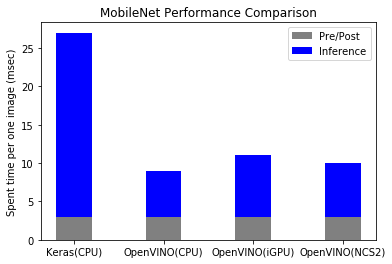

In [13]:
import matplotlib.pyplot as plt
import numpy as np

w = 0.4

Y1 = [tf_total_time - tf_infer_time, cpu_total_time - cpu_infer_time, gpu_total_time - gpu_infer_time, ncs_total_time - ncs_infer_time]
Y2 = [tf_infer_time, cpu_infer_time, gpu_infer_time, ncs_infer_time]

X = np.arange(len(Y1))

plt.bar(X, Y1, color='gray', width=w, label='Pre/Post', align="center")
plt.bar(X, Y2, color='blue', width=w, bottom=Y1, label='Inference', align="center")

plt.legend(loc="best")
plt.title('MobileNet Performance Comparison')
plt.ylabel("Spent time per one image (msec)")

plt.xticks(X, ['Keras(CPU)','OpenVINO(CPU)','OpenVINO(iGPU)','OpenVINO(NCS2)'])

plt.show()